In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Consumer():

    def __init__(self, w):
        "Initialize consumer with w dollars of wealth"
        self.wealth = w

    def earn(self, y):
        "The consumer earns y dollars"
        self.wealth += y

    def spend(self, x):
        "The consumer spends x dollars if feasible"
        new_wealth = self.wealth - x
        if new_wealth < 0:
            print("Insufficent funds")
        else:
            self.wealth = new_wealth

In [3]:
print(Consumer.__dict__)  # Show __dict__ attribute of class object

{'__module__': '__main__', '__init__': <function Consumer.__init__ at 0x7f9819919c10>, 'earn': <function Consumer.earn at 0x7f9819919ca0>, 'spend': <function Consumer.spend at 0x7f9819919d30>, '__dict__': <attribute '__dict__' of 'Consumer' objects>, '__weakref__': <attribute '__weakref__' of 'Consumer' objects>, '__doc__': None}


In [4]:
c1 = Consumer(10)
c1.earn(10)
c1.wealth


20

In [8]:
class Solow():
    r"""
    Implements the Solow growth model with the update rule

        k_{t+1} = [(s z k^α_t) + (1 - δ)k_t] /(1 + n)

    """
    def __init__(self, n=0.05,  # population growth rate
                       s=0.25,  # savings rate
                       δ=0.1,   # depreciation rate
                       α=0.3,   # share of labor
                       z=2.0,   # productivity
                       k=1.0):  # current capital stock

        self.n, self.s, self.δ, self.α, self.z = n, s, δ, α, z
        self.k = k
    
    def h(self):
        "Evaluate the h function"
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Apply the update rule
        return (s * z * self.k**α + (1 - δ) * self.k) / (1 + n)

    def update(self):
        "Update the current state (i.e., the capital stock)."
        self.k =  self.h()
        
    def steady_state(self):
        "Compute the steady state value of capital."
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Compute and return steady state
        return ((s * z) / (n + δ))**(1 / (1 - α))

    def generate_sequence(self, t):
        "Generate and return a time series of length t"
        path = []
        for i in range(t):
            path.append(self.k)
            self.update()
        return path

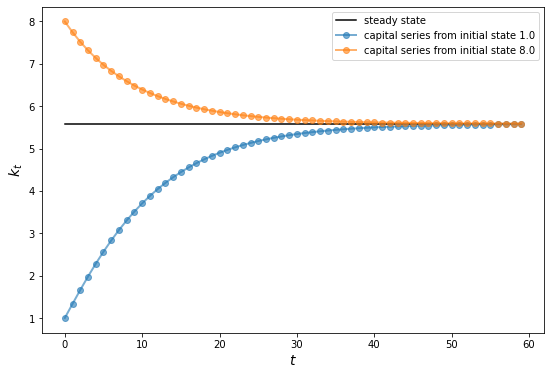

In [9]:
s1 = Solow()
s2 = Solow(k=8.0)

T = 60
fig, ax = plt.subplots(figsize=(9, 6))

# Plot the common steady state value of capital
ax.plot([s1.steady_state()]*T, 'k-', label='steady state')

# Plot time series for each economy
for s in s1, s2:
    lb = f'capital series from initial state {s.k}'
    ax.plot(s.generate_sequence(T), 'o-', lw=2, alpha=0.6, label=lb)

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$k_t$', fontsize=14)
ax.legend()
plt.show()

In [10]:
from scipy.integrate import quad

class Market:

    def __init__(self, ad, bd, az, bz, tax):
        """
        Set up market parameters.  All parameters are scalars.  See
"""
        self.ad, self.bd, self.az, self.bz, self.tax = ad, bd, az, bz, tax
        if ad < az:
            raise ValueError('Insufficient demand.')
    def price(self):
        "Compute equilibrium price"
        return  (self.ad - self.az + self.bz * self.tax) / (self.bd + self.bz)

    def quantity(self):
        "Compute equilibrium quantity"
        return  self.ad - self.bd * self.price()

    def consumer_surp(self):
        "Compute consumer surplus"
        # == Compute area under inverse demand function == #
        integrand = lambda x: (self.ad / self.bd) - (1 / self.bd) * x
        area, error = quad(integrand, 0, self.quantity())
        return area - self.price() * self.quantity()
     
    def producer_surp(self):
        "Compute producer surplus"
        #  == Compute area above inverse supply curve, excluding tax == #
        integrand = lambda x: -(self.az / self.bz) + (1 / self.bz) * x
        area, error = quad(integrand, 0, self.quantity())
        return (self.price() - self.tax) * self.quantity() - area

    def taxrev(self):
        "Compute tax revenue"
        return self.tax * self.quantity()
    
    def inverse_demand(self, x):
        "Compute inverse demand"
        return self.ad / self.bd - (1 / self.bd)* x

    def inverse_supply(self, x):
        "Compute inverse supply curve"
        return -(self.az / self.bz) + (1 / self.bz) * x + self.tax

    def inverse_supply_no_tax(self, x):
        "Compute inverse supply curve without tax"
        return -(self.az / self.bz) + (1 / self.bz) * x

In [11]:
baseline_params = 15, .5, -2, .5, 3
m = Market(*baseline_params)
print("equilibrium price = ", m.price())
print("consumer surplus = ", m.consumer_surp())

equilibrium price =  18.5
consumer surplus =  33.0625


In [12]:
baseline_params = 15, .5, -2, .5, 3
m = Market(*baseline_params)

q_max = m.quantity() * 2
q_grid = np.linspace(0.0, q_max, 100)
pd = m.inverse_demand(q_grid)
ps = m.inverse_supply(q_grid)
psno = m.inverse_supply_no_tax(q_grid)

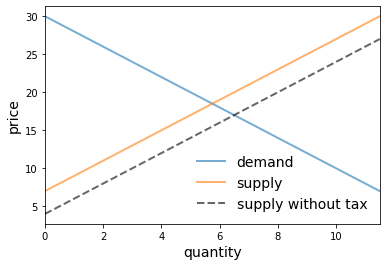

In [13]:
fig, ax = plt.subplots()
ax.plot(q_grid, pd, lw=2, alpha=0.6, label='demand')
ax.plot(q_grid, ps, lw=2, alpha=0.6, label='supply')
ax.plot(q_grid, psno, '--k', lw=2, alpha=0.6, label='supply without tax')
ax.set_xlabel('quantity', fontsize=14)
ax.set_xlim(0, q_max)
ax.set_ylabel('price', fontsize=14)
ax.legend(loc='lower right', frameon=False, fontsize=14)
plt.show()

In [14]:
def deadw(m):
    "Computes deadweight loss for market m."
    # == Create analogous market with no tax == #
    m_no_tax = Market(m.ad, m.bd, m.az, m.bz, 0)
    # == Compare surplus, return difference == #
    surp1 = m_no_tax.consumer_surp() + m_no_tax.producer_surp()
    surp2 = m.consumer_surp() + m.producer_surp() + m.taxrev()
    return surp1 - surp2

In [15]:
baseline_params = 15, .5, -2, .5, 3
m = Market(*baseline_params)
deadw(m)  # Show deadweight loss

1.125

In [19]:
class Chaos():
  """
  Models the dynamical system :math:`x_{t+1} = r x_t (1 - x_t)`
  """
  def __init__(self, x0, r):
      """
      Initialize with state x0 and parameter r
      """
      self.x, self.r = x0, r
        
  def update(self):
      "Apply the map to update state."
      self.x =  self.r * self.x *(1 - self.x)

  def generate_sequence(self, n):
      "Generate and return a sequence of length n."
      path = []
      for i in range(n):
          path.append(self.x)
          self.update()
      return path

In [20]:
ch = Chaos(0.1, 4.0)     # x0 = 0.1 and r = 0.4
ch.generate_sequence(5)  # First 5 iterates

[0.1, 0.36000000000000004, 0.9216, 0.28901376000000006, 0.8219392261226498]

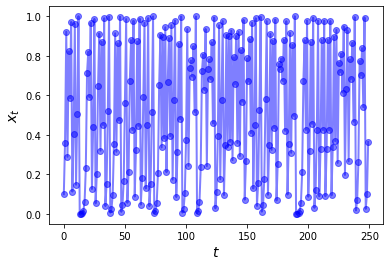

In [21]:
ch = Chaos(0.1, 4.0)
ts_length = 250

fig, ax = plt.subplots()
ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$x_t$', fontsize=14)
x = ch.generate_sequence(ts_length)
ax.plot(range(ts_length), x, 'bo-', alpha=0.5, lw=2, label='$x_t$')
plt.show()

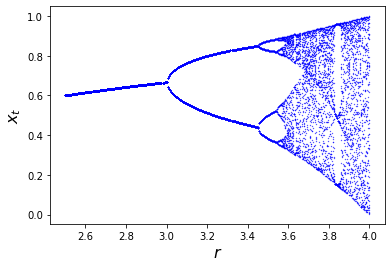

In [22]:
fig, ax = plt.subplots()
ch = Chaos(0.1, 4)
r = 2.5
while r < 4:
    ch.r = r
    t = ch.generate_sequence(1000)[950:]
    ax.plot([r] * len(t), t, 'b.', ms=0.6)
    r = r + 0.005

ax.set_xlabel('$r$', fontsize=16)
ax.set_ylabel('$x_t$', fontsize=16)
plt.show()

In [23]:
x = (10, 20)
len(x)

2

In [24]:
class Foo:

    def __len__(self):
        return 42
f = Foo()
len(f)

42

In [25]:
class Foo:

    def __call__(self, x):
        return x + 42
f = Foo()
f(8)  # Exactly equivalent to f.__call__(8)

50

In [26]:
class ECDF:
    def __init__(self, observations):
        self.observations=observations
    def __call__(self, x):
        counter=0
        for obs in self.observations:
            if obs<=x:
                counter+=1
        return counter/len(self.observations)

In [27]:
from random import uniform
samples=[uniform(0,1) for i in range(10)]
F=ECDF(samples)
print(F(0.5))

0.5


In [28]:
F.observations=[uniform(0,1) for i in range(1000)]
print(F(0.5))

0.493


In [29]:
class Polynomial:
    def __init__(self, coefficients):
        self.coefficients=coefficients
    def __call__(self, x):
        y=0
        for i, a in enumerate(self.coefficients):
            y+=a*x**i
        return y
    def differentiate(self):
        new_coefficients=[]
        for i, a in enumerate(self.coefficients):
            new_coefficients.append(i*a)
        del new_coefficients[0]
        self.coefficients=new_coefficients
        return new_coefficients